<br/><br/>
![h2o-sklearn](../../images/h2o-sklearn.png)


# `skutil`

*Skutil brings the best of both worlds to H2O and sklearn, delivering an easy transition into the world of distributed computing that H2O offers, while providing the same, familiar interface that sklearn users have come to know and love. This notebook will give an example of how to use *`skutil`* preprocessors with *`H2OEstimator`*s and *`H2OFrame`*s.*

Author: *Taylor G Smith*

Contact: *tgsmith61591@gmail.com*


__Python packages you will need__:
  - `python` 2.7
  - `numpy` >= 1.6
  - `scipy` >= 0.17
  - `scikit-learn` >= 0.16
  - `pandas` >= 0.18
  - `cython` >= 0.22
  - `h2o` >= 3.8.2.9
  
 
__Misc. requirements__ (for compiling Fortran a la `f2py`):
  - `gfortran`
  - `gcc`
    - Note that the El Capitan Apple Developer tool upgrade necessitates upgrading this! Use:
    
        brew upgrade gcc


This notebook is intended for an audience with a working understanding of machine learning principles and a background in Python development, ideally `sklearn` or `H2O` users. Note that this notebook is *not* designed to teach machine learning, but to demonstrate use of the `skutil` package.


### Procession of events:
  - Data split&mdash;*always the first step!*
  - Preprocessing:
    - Balance response classes in train set
    - Remove near-zero variance features
    - Remove multicollinear features
  - Modeling
    - Formulate pipeline
    - Grid search
  - Model selection
    - ... (not shown here, but other models built)
    - All models finally evaluated against holdout
  - Model persistence

In [3]:
from __future__ import print_function, division, absolute_import
import warnings
import skutil
import sklearn
import h2o
import pandas as pd
import numpy as np

# we'll be plotting inline...
%matplotlib inline

print('Skutil version:  %s' % skutil.__version__)
print('H2O version:     %s' % h2o.__version__)
print('Numpy version:   %s' % np.__version__)
print('Sklearn version: %s' % sklearn.__version__)
print('Pandas version:  %s' % pd.__version__)

Skutil version:  0.0.57.working
H2O version:     3.10.0.7
Numpy version:   1.11.1
Sklearn version: 0.18
Pandas version:  0.19.0


### Initialize H2O

First, we'll start our H2O cluster...

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # I started this cluster up via CLI with:
    #     $ java -Xmx2g -jar /anaconda/h2o_jar/h2o.jar
    h2o.init(ip='10.7.85.110', port=54321, start_h2o=False)

Checking whether there is an H2O instance running at http://10.7.85.110:54321. connected.


H2O cluster uptime:,21 secs
H2O cluster version:,3.10.0.7
H2O cluster version age:,"14 days, 17 hours and 45 minutes"
H2O cluster name:,fp7y
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://10.7.85.110:54321
H2O connection proxy:,None


### Load data

We'll load sklearn's breast cancer data. Using skutil's `from_pandas` method, we can upload a Pandas frame to the H2O cloud

In [5]:
from sklearn.datasets import load_breast_cancer
from skutil.h2o.util import from_pandas

# import data, load into pandas
bc = load_breast_cancer()
X = pd.DataFrame.from_records(data=bc.data, columns=bc.feature_names)
X['target'] = bc.target

# push to h2o cloud
X = from_pandas(X)
print(X.shape)
X.head()

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
(568, 31)


mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902,0
19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,0
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0
20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678,0
12.45,15.7,82.57,477.1,0.1278,0.17,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.00751,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244,0
18.25,19.98,119.6,1040,0.09463,0.109,0.1127,0.074,0.1794,0.05742,0.4467,0.7732,3.18,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.2,1606,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.377,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.6,897,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151,0
13,21.82,87.5,519.8,0.1273,0.1932,0.1859,0.09353,0.235,0.07389,0.3063,1.002,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.2,739.3,0.1703,0.5401,0.539,0.206,0.4378,0.1072,0
12.46,24.04,83.97,475.9,0.1186,0.2396,0.2273,0.08543,0.203,0.08243,0.2976,1.599,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.01008,15.09,40.68,97.65,711.4,0.1853,1.058,1.105,0.221,0.4366,0.2075,0
16.02,23.24,102.7,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.187,2.466,40.51,0.004029,0.009269,0.01101,0.007591,0.0146,0.003042,19.19,33.88,123.8,1150,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452,0


In [6]:
# Here are our feature names:
x = list(bc.feature_names)
y = 'target'

## train/test split

Sklearn provides a great mechanism for splitting data into a train and validation set. Skutil provides the same mechanism for h2o frames. This cell does the following:

  - Makes the response variable an enum
  - Creates two splits:
    - `X_train`: 75%
    - `X_val`: 25%

In [7]:
from skutil.h2o import h2o_train_test_split

# first, let's make sure our target is a factor
X[y] = X[y].asfactor()

# we'll use 75% of the data for training, 25%
X_train, X_val = h2o_train_test_split(X, train_size=0.75, random_state=42)

# make sure we did it right...
# assert X.shape[0] == (X_train.shape[0] + X_val.shape[0])

## preprocessing with `skutil.h2o`

Skutil provides an `h2o` module which delivers some skutil `feature_selection` classes that can operate on an H2OFrame. Each `BaseH2OTransformer` has the following `__init__` signature:

    BaseH2OTransformer(self, feature_names=None, target_feature=None)
    
The selector will only operate on the `feature_names` (if provided&mdash;else it will operate on all features) and will always exclude the `target_feature`.

The first step would be to ensure our data is balanced, as we don't want imbalanced minority/majority classes. The problem of class imbalance is [well-documented](http://www3.nd.edu/~dial/publications/chawla2005data.pdf), and many solutions have been proposed. Skutil provides a mechanism by which we could over-sample the minority class using the `H2OOversamplingClassBalancer`, or under-sample the majority class using the `H2OUndersamplingClassBalancer`.

Fortunately for us, the classes in this dataset are fairly balanced, so we can move on to the next piece.

### Handling near-zero variance

Some predictors contain few unique values and are considered "near-zero variance" predictors. For parametric many models, this may cause the fit to be unstable.  Skutil's `NearZeroVarianceFilterer` and `H2ONearZeroVarianceFilterer` drop features with variance below a given threshold (based on [caret's](https://topepo.github.io/caret/pre-processing.html#nzv) preprocessor).

__Note__: sklearn added this in 0.18 (released last week) under [VarianceThreshold](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html)

In [8]:
from skutil.h2o import H2ONearZeroVarianceFilterer

# Let's determine whether we're at risk for any near-zero variance
nzv = H2ONearZeroVarianceFilterer(feature_names=x, target_feature=y, threshold=1e-4)
nzv.fit(X_train)

# let's see if anything was dropped...
nzv.drop_

//anaconda/lib/python2.7/site-packages/h2o/expr.py:155: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return "[%s]" % " ".join("NaN" if i == 'NaN' or math.isnan(i) else str(i) for i in arg)


['mean fractal dimension',
 'smoothness error',
 'concave points error',
 'symmetry error',
 'fractal dimension error']

### Multicollinearity

Multicollinearity (MC) can be detrimental to the fit of parametric models (for our example, we're going to use a tree-based model, which is non-parametric, but the demo is still useful), and can cause confounding results in some models' variable importances. With `skutil`, we can filter out features that are correlated beyond a certain absolute threshold.  When a violating correlation is identified, the feature with the highest mean absolute correlation is removed ([see also](http://blog.minitab.com/blog/adventures-in-statistics/what-are-the-effects-of-multicollinearity-and-when-can-i-ignore-them)).

Before filtering out collinear features, let's take a look at the correlation matrix.

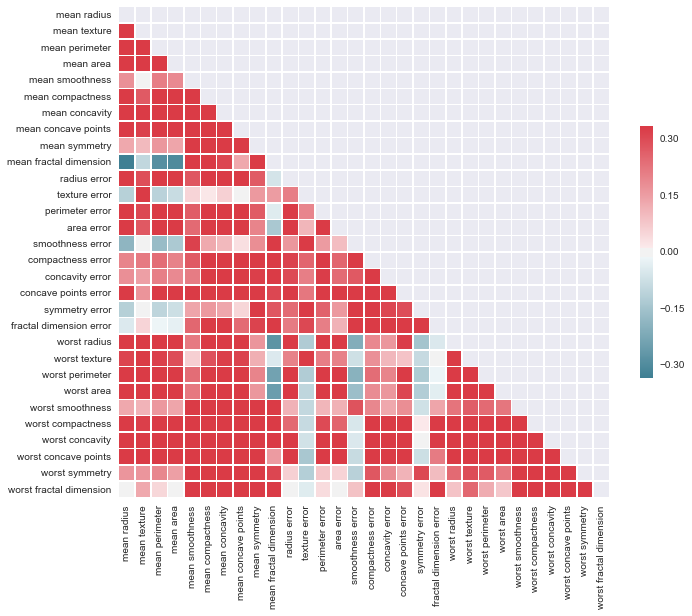

In [9]:
from skutil.h2o import h2o_corr_plot

# note that we want to exclude the target!!
h2o_corr_plot(X_train[x], xticklabels=x, yticklabels=x)

In [10]:
from skutil.h2o import H2OMulticollinearityFilterer

# Are we at risk of any multicollinearity?
mcf = H2OMulticollinearityFilterer(feature_names=x, target_feature=y, threshold=0.90)
mcf.fit(X_train)

# we can look at the dropped features
mcf.correlations_

[Dropped: mean perimeter, Corr_feature: mean radius, abs_corr: 0.99822, MAC: 0.47980,
 Dropped: mean radius, Corr_feature: mean area, abs_corr: 0.98854, MAC: 0.44724,
 Dropped: worst texture, Corr_feature: mean texture, abs_corr: 0.91160, MAC: 0.26108,
 Dropped: worst radius, Corr_feature: mean area, abs_corr: 0.96228, MAC: 0.45561,
 Dropped: worst perimeter, Corr_feature: mean area, abs_corr: 0.95864, MAC: 0.44955,
 Dropped: worst area, Corr_feature: mean area, abs_corr: 0.95625, MAC: 0.39923,
 Dropped: mean concavity, Corr_feature: mean concave points, abs_corr: 0.91567, MAC: 0.54588,
 Dropped: worst concave points, Corr_feature: mean concave points, abs_corr: 0.91019, MAC: 0.48403,
 Dropped: perimeter error, Corr_feature: radius error, abs_corr: 0.97511, MAC: 0.36587,
 Dropped: radius error, Corr_feature: area error, abs_corr: 0.95979, MAC: 0.32329]

### Dropping features

As you'll see in the next section (Pipelines), where certain preprocessing steps take place matters. If there are a subset of features on which you don't want to model or process, you can drop them out. Sometimes this is more effective than creating a list of potentially thousands of feature names to pass as the `feature_names` parameter.

In [11]:
from skutil.h2o import H2OFeatureDropper

# maybe I don't like 'mean fractal dimension'
dropper = H2OFeatureDropper(feature_names=['mean fractal dimension'], target_feature=y)
transformed = dropper.fit_transform(X_train)

# we can ensure it's not there
assert not 'mean fractal dimension' in transformed.columns

### `skutil.h2o` modeling

Skutil's `h2o` module allows us to form the `Pipeline` objects we're familiar with from sklearn.  This permits us to string a series of preprocessors together, with an optional `H2OEstimator` as the last step.  Like sklearn `Pipeline`s, the first argument is a single list of length-two tuples (where the first arg is the name of the step, and the second is the Estimator/Transformer), however the `H2OPipeline` takes two more arguments: `feature_names` and `target_feature`.

__Note__ that the `feature_names` arg is the names the *first* preprocessor will operate on; after that, all remaining feature names (i.e., not the target) will be passed to the next processor.

In [44]:
from skutil.h2o import H2OPipeline
from h2o.estimators import H2ORandomForestEstimator
from skutil.h2o.metrics import h2o_accuracy_score # same as sklearn's, but with H2OFrames

# let's fit a pipeline with our estimator...
pipe = H2OPipeline([
        ('nzv', H2ONearZeroVarianceFilterer(threshold=1e-1)),
        ('mcf', H2OMulticollinearityFilterer(threshold=0.95)),
        ('rf' , H2ORandomForestEstimator(ntrees=50, max_depth=8, min_rows=5))
    ], 
    
    # feature_names is the set of features the first transformer
    # will operate on. The remaining features will be passed
    # to the next step
    feature_names=x, 
    target_feature=y)


# fit...
pipe = pipe.fit(X_train)


# eval accuracy on validation set
pred = pipe.predict(X_val)
actual = X_val[y]
pred = pred['predict']
print('Validation accuracy: %.5f' % h2o_accuracy_score(actual, pred))

drf Model Build progress: |███████████████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████████████████████████| 100%
Validation accuracy: 0.92254


### Which features were retained?

We can see which features were modeled on with the `training_cols_` attribute of the fitted pipe.

In [45]:
pipe.training_cols_

['mean radius',
 'mean texture',
 'texture error',
 'perimeter error',
 'area error',
 'worst texture',
 'worst area']

### Hyperparameter optimization

With relatively little effort, we got > 93% accuracy on our validation set! Can we improve that? We can use `sklearn`-esque grid searches, which also allow us to search over preprocessor objects to optimize a set of hyperparameters.

In [46]:
from skutil.h2o import H2ORandomizedSearchCV
from skutil.h2o import H2OKFold
from scipy.stats import uniform, randint

# define our random state
rand_state = 2016

# we have the option to choose the model that maximizes CV scores,
# or the model that minimizes std deviations between CV scores.
# let's choose the former for this example
minimize = 'bias'

# let's redefine our pipeline
pipe = H2OPipeline([
        ('nzv', H2ONearZeroVarianceFilterer()),
        ('mcf', H2OMulticollinearityFilterer()),
        ('rf' , H2ORandomForestEstimator(seed=rand_state))
    ])

# our hyperparameters over which to search...
hyper = {
    'nzv__threshold'    : uniform(1e-4,1e-1),  # see scipy.stats.uniform:
    'mcf__threshold'    : uniform(0.7, 0.29),  # uniform in range (0.7 + 0.29)
    'rf__ntrees'        : randint(50, 100),
    'rf__max_depth'     : randint(10, 12),
    'rf__min_rows'      : randint(25, 50)
}

# define our grid search
search = H2ORandomizedSearchCV(
        estimator=pipe,
        param_grid=hyper,
        feature_names=x,
        target_feature=y,
        n_iter=2, # keep it small for our demo...
        random_state=rand_state,
        scoring='accuracy_score',
        cv=H2OKFold(n_folds=3, shuffle=True, random_state=rand_state),
        verbose=3,
        minimize=minimize
    )

# fit
search.fit(X_train)

[CV (iter 0, fold 0)] Target: target; rf__ntrees=84, rf__min_rows=32, mcf__threshold=0.960044553383, rf__max_depth=11, nzv__threshold=0.0731239214356 
drf Model Build progress: |███████████████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████████████████████████| 100%

[CV (iter 0, fold 0)]  Target: target; rf__ntrees=84, rf__min_rows=32, mcf__threshold=0.960044553383, rf__max_depth=11, nzv__threshold=0.0731239214356, score=0.915493 -  10.5s


[CV (iter 0, fold 1)] Target: target; rf__ntrees=84, rf__min_rows=32, mcf__threshold=0.960044553383, rf__max_depth=11, nzv__threshold=0.0731239214356 
drf Model Build progress: |███████████████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████████████████████████| 100%

[CV (iter 0, fold 1)]  Target: target; rf__ntrees=84, rf__min_rows=32, mcf__threshold=0.960044553383, rf__max_dept

H2ORandomizedSearchCV(cv=H2OKFold(n_folds=3, random_state=2016, shuffle=True),
           estimator=None,
           feature_names=['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness e...ompactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension'],
           iid=True, minimize='bias', n_iter=2, n_jobs=1,
           param_grid={'rf__ntrees': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11d88aa10>, 'rf__min_rows': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11e86e190>, 'mcf__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11edefe90>, 'rf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11e86e650>, 'nzv__threshold': <scipy.stats._distn_infrastructure.rv_

### Model evaluation

Beyond merely observing our validation set score, we can dig into the cross validation scores of each model in our H2O grid search, and select the model that has not only the best mean score, but the model that minimizes variability in the CV scores.

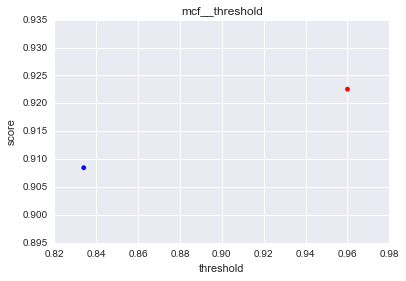

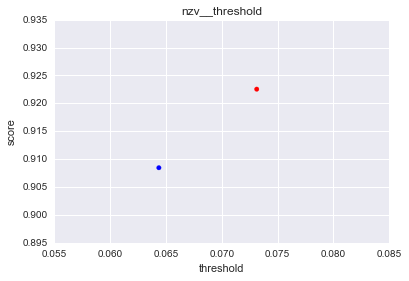

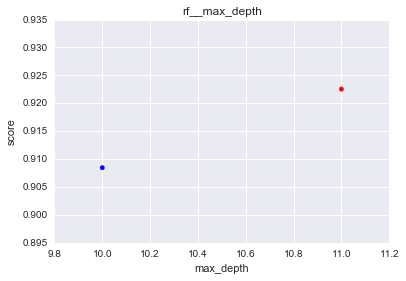

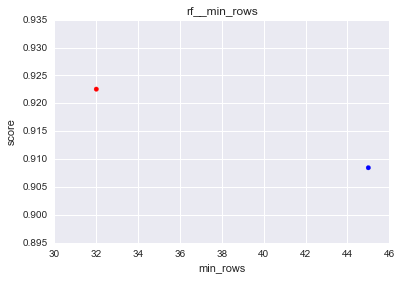

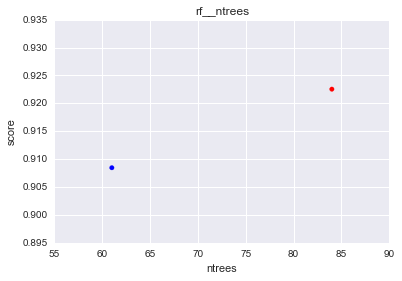

,mcf__threshold,nzv__threshold,rf__max_depth,rf__min_rows,rf__ntrees,score,std
0,0.960045,0.073124,11,32,84,0.922535,0.073901
1,0.834006,0.064357,10,45,61,0.908451,0.068551


In [47]:
from skutil.utils import report_grid_score_detail

# now let's look deeper...
sort_by = 'std' if minimize == 'variance' else 'score'
report_grid_score_detail(search, charts=True, sort_results=True, 
                         ascending=minimize=='variance',
                         sort_by=sort_by)

### Variable importance

We can easily extract the best model's variable importances like so:

In [48]:
search.varimp()

,variable,relative_importance,scaled_importance,percentage
0,worst area,2023.382446,1.000000,0.375825
1,mean radius,1680.709229,0.830643,0.312177
2,area error,1002.707581,0.495560,0.186244
3,mean texture,350.455719,0.173203,0.065094
4,worst texture,175.689484,0.086830,0.032633
5,perimeter error,145.774796,0.072045,0.027076
6,texture error,5.121491,0.002531,0.000951


### Model evaluation&mdash;introduce the *validation* set

So our best estimator achieves a mean cross validation accuracy of 93%! We can predict on our best estimator as follows:

In [49]:
val_preds = search.predict(X_val)

# print accuracy
print('Validation accuracy: %.5f' % h2o_accuracy_score(actual, val_preds['predict']))
val_preds.head()

drf prediction progress: |████████████████████████████████████████████████████████████████████| 100%
Validation accuracy: 0.89437


predict,p0,p1
0,0.841681,0.158319
1,0.122403,0.877597
0,0.639047,0.360953
0,0.85755,0.14245
0,0.825957,0.174043
0,0.984232,0.0157683
0,0.706336,0.293664
1,0.120702,0.879298
0,0.994637,0.00536294
0,0.365147,0.634853


### Model selection

(__Not shown:__ other models we built and evaluated against the validation set (once!)&mdash;we only introduce the holdout set at the __*very*__ end)

In a real situation, you probably will have a holdout set, and will have built several models. After you have a collection of models and you'd like to select one, you introduce the holdout set only *once*!

## Model persistence

When we find a model that performs well, we can save it to disk for later use:

In [50]:
import os

# get absolute path
cwd = os.getcwd()
model_path = os.path.join(cwd, 'grid.pkl')

# save -- it's that easy!!!
search.save(location=model_path, warn_if_exists=False)

### Loading and making predictions

In [51]:
search = H2ORandomizedSearchCV.load(model_path)
new_predictions = search.predict(X_val)
new_predictions.head()

drf prediction progress: |████████████████████████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.841681,0.158319
1,0.122403,0.877597
0,0.639047,0.360953
0,0.85755,0.14245
0,0.825957,0.174043
0,0.984232,0.0157683
0,0.706336,0.293664
1,0.120702,0.879298
0,0.994637,0.00536294
0,0.365147,0.634853


# Cleanup

Always make sure to shut down your cluster...

In [52]:
h2o.shutdown(prompt=False) # shutdown cluster
os.unlink(model_path) # remove the pickle file...

H2O session _sid_af85 closed.
